In [110]:
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.datasets import ImageFolder, MNIST
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import glob
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=(0.5), std=(0.5))
        ])
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(MNIST('data', train=True, download=True, transform=transform),batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(MNIST('data', train=False, download=True, transform=transform),batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...


/home/pluto/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [6]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28*28, 256*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.trans_conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv4 = nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
    
    def forward(self, x):
        x=x.reshape(-1,28*28)
        x = self.fc(x)
        x = x.reshape(-1, 256, 7, 7)
        x = F.relu(self.trans_conv1(x))
        x = F.relu(self.trans_conv2(x))
        x = F.relu(self.trans_conv3(x))
        x = self.trans_conv4(x)
        x = torch.tanh(x)
        
        return x  




In [15]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        
        return x


def Discriminataor_resnet18():
    """Constructs a ResNet-18 model."""
    out = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=1,
                   grayscale=True)
    return out

In [16]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

D = Discriminataor_resnet18()
G = Generator()

D = D.to(device)
G = G.to(device)

Loss = nn.BCEWithLogitsLoss()
def discriminator_real_loss(real_out):
    real_label = torch.ones(size = real_out.shape, dtype=torch.float, device=device)
    real_loss = Loss(real_out,real_label)

    return real_loss

def discriminator_fake_loss(fake_out):
    fake_label = torch.zeros(size = fake_out.shape, dtype=torch.float, device=device)
    fake_loss = Loss(fake_out,fake_label)
    return fake_loss

def discriminator_loss(real_out, fake_out):
    real_loss = discriminator_real_loss(real_out)
    fake_loss = discriminator_fake_loss(fake_out)
    total_loss = (real_loss + fake_loss)
    return total_loss


cuda:0


In [17]:
def generator_loss(gen_disc_out):
    label = torch.ones(gen_disc_out.shape).to(device)
    gen_loss = Loss(gen_disc_out,label)
    return gen_loss

In [18]:
disc_opt = optim.Adam(D.parameters(), lr = 0.0002, betas = (0.5, 0.999))
gen_opt = optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [19]:

def random_noise_generator(batch_size, dim):
    return torch.rand(batch_size, dim)*2 - 1
    
def train(D, G, disc_opt, gen_opt, train_dl, batch_size = 32, epochs = 20, gen_input_size = 28*28):
    
    disc_losses = []
    gen_losses = []
    
    sample_size = 10
    fixed_samples = random_noise_generator(sample_size, gen_input_size)
    fixed_samples = fixed_samples.float().to(device)
    
    D.train()
    G.train()
    
    for epoch in range(epochs + 1):
        
        disc_loss_total = 0
        gen_loss_total = 0
        gen_out = 0
        
        for idx,batch in enumerate(train_dl):
            
            train_x,_ = batch
            train_x = train_x.float().to(device)
            disc_opt.zero_grad()
            
            train_x = train_x*2 - 1          
            train_x = train_x              
            real_out = D(train_x)   
            
            disc_gen_in = random_noise_generator(batch_size, gen_input_size)
            disc_gen_in = disc_gen_in.float().to(device) 
            disc_gen_out = G(disc_gen_in).detach() 
            fake_out = D(disc_gen_out)
            
            disc_loss = discriminator_loss(real_out, fake_out) 
            disc_loss_total += disc_loss
            disc_loss.backward()
            disc_opt.step()  
        
            gen_opt.zero_grad()
            
            gen_out = G(disc_gen_in)    
            gen_disc_out = D(gen_out)       
            gen_loss = generator_loss(gen_disc_out)  
            gen_loss_total += gen_loss
            gen_loss.backward()
            gen_opt.step()
        
        disc_losses.append(disc_loss_total)
        gen_losses.append(gen_loss_total)

        if epoch == 0 or epoch == 10 or epoch ==20:
            G.eval()                       
            samples = G(fixed_samples)
            G.train()                   
            print("image:",samples.shape,fixed_samples.shape)
            
            
            samples1 = samples.permute(0,2,3,1).detach().cpu().numpy()
            for i in range(10):
              img = samples1[i]
              print(img.shape)
              img = img.reshape(28,28)
              plt.imshow(img)
              plt.show()
        
        print("Epoch ", epoch, ": Discriminator Loss = ", disc_loss_total.item()/len(train_dl), ", Generator Loss = ", gen_loss_total.item()/len(train_dl))    
    
    return disc_losses, gen_losses

image: torch.Size([10, 1, 28, 28]) torch.Size([10, 784])
(28, 28, 1)


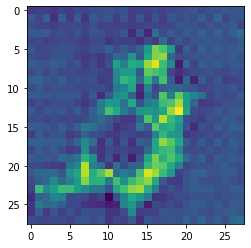

(28, 28, 1)


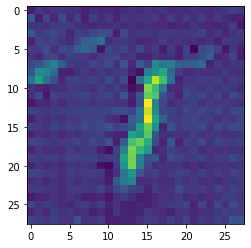

(28, 28, 1)


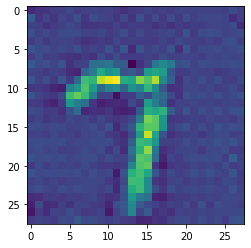

(28, 28, 1)


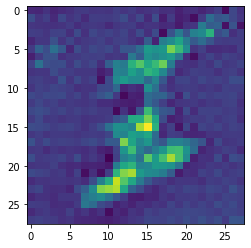

(28, 28, 1)


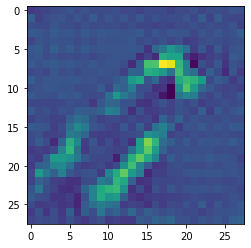

(28, 28, 1)


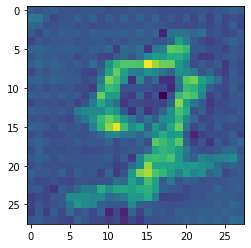

(28, 28, 1)


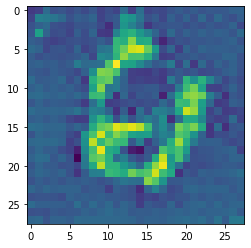

(28, 28, 1)


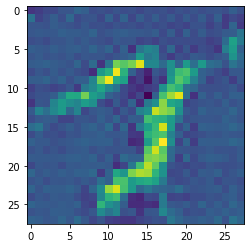

(28, 28, 1)


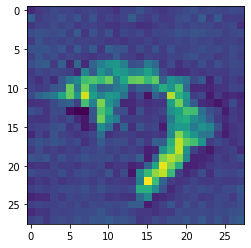

(28, 28, 1)


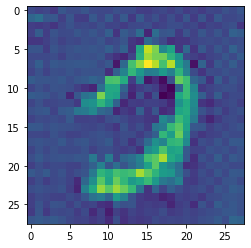

Epoch  0 : Discriminator Loss =  0.12258370768229167 , Generator Loss =  5.279846875
Epoch  1 : Discriminator Loss =  0.09536038411458334 , Generator Loss =  5.719136458333334
Epoch  2 : Discriminator Loss =  0.08476861165364584 , Generator Loss =  6.2707703125
Epoch  3 : Discriminator Loss =  0.07293505859375 , Generator Loss =  6.806580729166667
Epoch  4 : Discriminator Loss =  0.06804459635416667 , Generator Loss =  6.958865104166667
Epoch  5 : Discriminator Loss =  0.06275858968098959 , Generator Loss =  7.6028276041666665
Epoch  6 : Discriminator Loss =  0.05623599853515625 , Generator Loss =  7.905939583333334
Epoch  7 : Discriminator Loss =  0.07846923828125 , Generator Loss =  7.7701953125
Epoch  8 : Discriminator Loss =  0.06659765218098958 , Generator Loss =  7.828767708333333
Epoch  9 : Discriminator Loss =  0.06414732666015625 , Generator Loss =  8.058997395833334
image: torch.Size([10, 1, 28, 28]) torch.Size([10, 784])
(28, 28, 1)


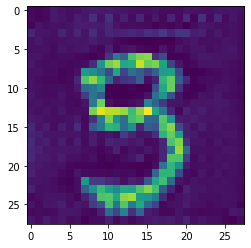

(28, 28, 1)


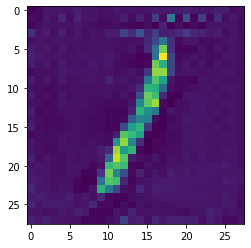

(28, 28, 1)


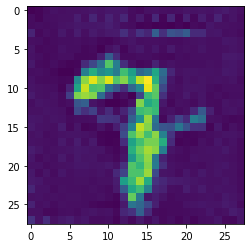

(28, 28, 1)


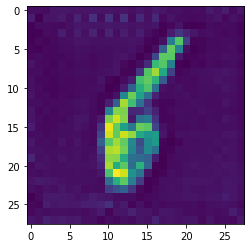

(28, 28, 1)


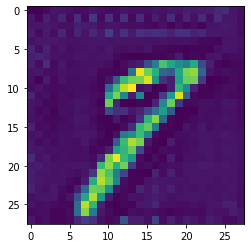

(28, 28, 1)


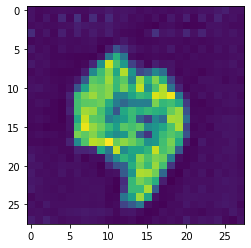

(28, 28, 1)


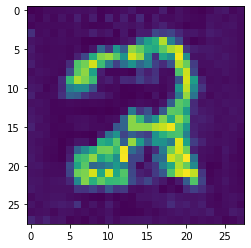

(28, 28, 1)


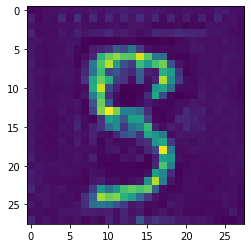

(28, 28, 1)


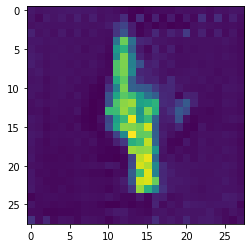

(28, 28, 1)


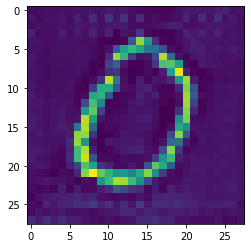

Epoch  10 : Discriminator Loss =  0.07364034830729167 , Generator Loss =  8.361915625
Epoch  11 : Discriminator Loss =  0.07061531575520834 , Generator Loss =  8.244197916666666
Epoch  12 : Discriminator Loss =  0.08505463053385416 , Generator Loss =  7.971192708333334
Epoch  13 : Discriminator Loss =  0.07768006998697917 , Generator Loss =  8.216985416666667
Epoch  14 : Discriminator Loss =  0.06436221516927083 , Generator Loss =  8.452051041666667
Epoch  15 : Discriminator Loss =  0.06878456217447916 , Generator Loss =  8.608995833333333
Epoch  16 : Discriminator Loss =  0.0692407958984375 , Generator Loss =  8.626819270833334
Epoch  17 : Discriminator Loss =  0.09346275227864584 , Generator Loss =  8.494878125
Epoch  18 : Discriminator Loss =  0.07609928385416667 , Generator Loss =  8.5182015625
Epoch  19 : Discriminator Loss =  0.05375769856770833 , Generator Loss =  9.199104166666666
image: torch.Size([10, 1, 28, 28]) torch.Size([10, 784])
(28, 28, 1)


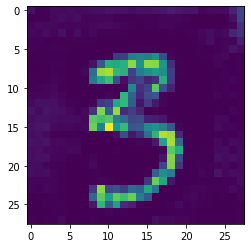

(28, 28, 1)


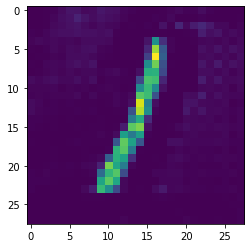

(28, 28, 1)


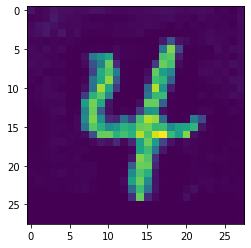

(28, 28, 1)


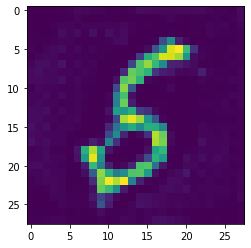

(28, 28, 1)


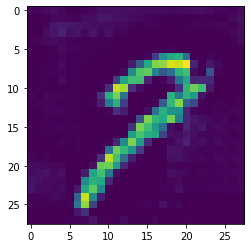

(28, 28, 1)


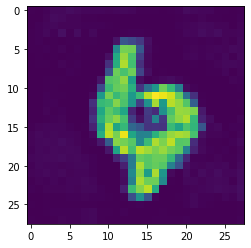

(28, 28, 1)


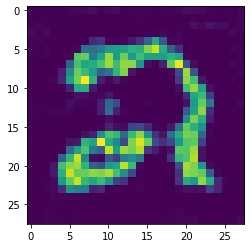

(28, 28, 1)


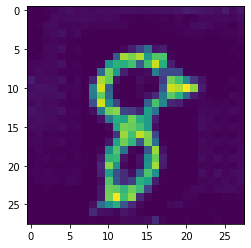

(28, 28, 1)


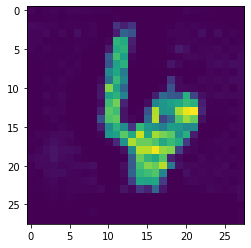

(28, 28, 1)


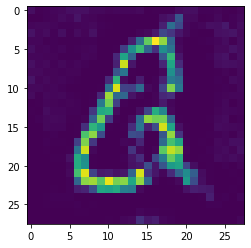

Epoch  20 : Discriminator Loss =  0.07001279296875 , Generator Loss =  9.108651041666667


In [13]:
disc_losses, gen_losses = train(D, G, disc_opt, gen_opt, train_dataloader, batch_size)

In [14]:
disc_losses_new = []
for i in disc_losses:
  disc_losses_new.append(i.item()/len(train_dataloader))
disc_losses_new = np.array(disc_losses_new)
disc_losses_new

array([0.12258371, 0.09536038, 0.08476861, 0.07293506, 0.0680446 ,
       0.06275859, 0.056236  , 0.07846924, 0.06659765, 0.06414733,
       0.07364035, 0.07061532, 0.08505463, 0.07768007, 0.06436222,
       0.06878456, 0.0692408 , 0.09346275, 0.07609928, 0.0537577 ,
       0.07001279])

In [15]:
gen_losses_new = []
for i in gen_losses:
  gen_losses_new.append(i.item()/len(train_dataloader))
gen_losses_new = np.array(gen_losses_new)
gen_losses_new

array([5.27984687, 5.71913646, 6.27077031, 6.80658073, 6.9588651 ,
       7.6028276 , 7.90593958, 7.77019531, 7.82876771, 8.0589974 ,
       8.36191562, 8.24419792, 7.97119271, 8.21698542, 8.45205104,
       8.60899583, 8.62681927, 8.49487812, 8.51820156, 9.19910417,
       9.10865104])

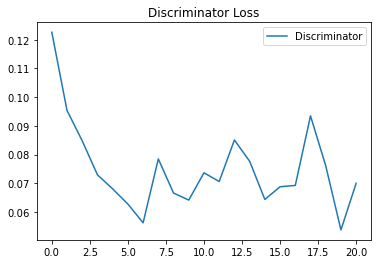

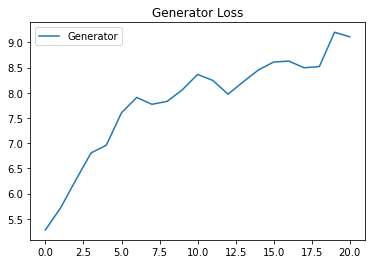

In [16]:
plt.title("Discriminator Loss")

plt.plot(np.arange(21),disc_losses_new, label='Discriminator')
plt.legend()
plt.show()

plt.title("Generator Loss")
plt.plot(np.arange(21),gen_losses_new, label='Generator')
plt.legend()
plt.show()


# Conditional gan

In [120]:
from torch.autograd import Variable
from torchvision.utils import make_grid
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.datasets import ImageFolder, MNIST
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import glob
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=(0.5), std=(0.5))
        ])
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(MNIST('data', train=True, download=True, transform=transform),batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(MNIST('data', train=False, download=True, transform=transform),batch_size=batch_size, shuffle=True)



class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(10, 10)

        self.fc = nn.Linear(110, 256*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.trans_conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv4 = nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
    
    def forward(self, z,labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x=torch.cat([z,c],1)

        x = self.fc(x)
        x = x.reshape(-1, 256, 7, 7)
        x = F.relu(self.trans_conv1(x))
        x = F.relu(self.trans_conv2(x))
        x = F.relu(self.trans_conv3(x))
        x = self.trans_conv4(x)
        x = torch.tanh(x)
        
        return x  

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim=2
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.linear_new = nn.Linear(794,784)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.label_emb = nn.Embedding(10, 10)
        self.linear_labels=nn.Linear(10,784)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.sigmoid = nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self,x,label):
#         x = x.view(x.size(0), 784)
        c = self.label_emb(label)
        c=  self.linear_labels(c)
        c=self.relu(c)
        c = c.view(c.size(0),1,28,28)
        x = torch.cat([x, c], 1)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        x=self.sigmoid(x)

        return x


def Discriminataor_resnet18():
    """Constructs a ResNet-18 model."""
    out = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=1,
                   grayscale=True)
    return out




In [124]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
generator_model = Generator()
generator_model = generator.to(device)
discriminator_model = Discriminataor_resnet18()
discriminator_model = discriminator.to(device)

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=0.0002,betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(generator_model.parameters(),  lr=0.0002,betas=(0.5,0.999))

def generator_train_step(batch_size, discriminator_model, generator_model, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(4, 5, batch_size))).cuda()
    fake_images = generator_model(z, fake_labels)
    validity = discriminator_model(fake_images, fake_labels)
    g_loss = criterion(validity.squeeze(1), Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

def discriminator_train_step(batch_size, discriminator_model, generator_model, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity.squeeze(1), Variable(torch.ones(batch_size)).cuda())
    
    z = torch.randn(batch_size, 100).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(4, 5, batch_size))).cuda()
    fake_images = generator_model(z, fake_labels)
    fake_validity = discriminator_model(fake_images, fake_labels)
    fake_loss = criterion(fake_validity.squeeze(1), Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss = d_loss *100
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()


device = ("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=0.00002,betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(generator_model.parameters(),  lr=0.00002,betas=(0.5,0.999))

def generator_train_step(batch_size, discriminator_model, generator_model, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(4, 5, batch_size))).cuda()
    fake_images = generator_model(z, fake_labels)
    validity = discriminator_model(fake_images, fake_labels)
    g_loss = criterion(validity.squeeze(1), Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

def discriminator_train_step(batch_size, discriminator_model, generator_model, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    real_validity = discriminator_model(real_images, labels)
    real_loss = criterion(real_validity.squeeze(1), Variable(torch.ones(batch_size)).cuda())
    z = torch.randn(batch_size, 100).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(4, 5, batch_size))).cuda()
    fake_images = generator_model(z, fake_labels)
    fake_validity = discriminator_model(fake_images, fake_labels)
    fake_loss = criterion(fake_validity.squeeze(1), Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss = d_loss *100
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()




cuda:0
cuda:0


torch.Size([10, 28, 28])
(10, 28, 28)
epoch: 0
tensor(9, device='cuda:0')


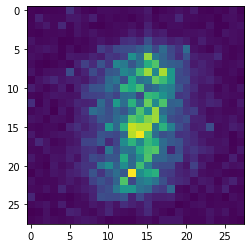

tensor(3, device='cuda:0')


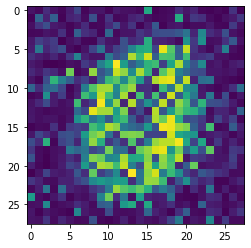

tensor(1, device='cuda:0')


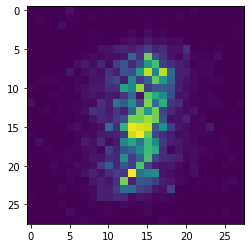

tensor(4, device='cuda:0')


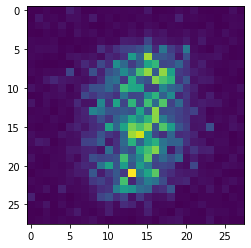

tensor(7, device='cuda:0')


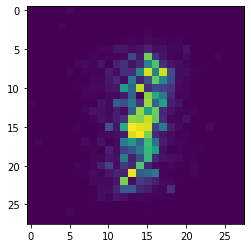

tensor(8, device='cuda:0')


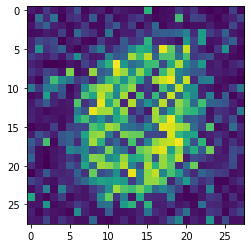

tensor(5, device='cuda:0')


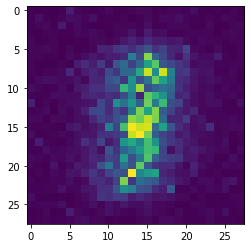

tensor(8, device='cuda:0')


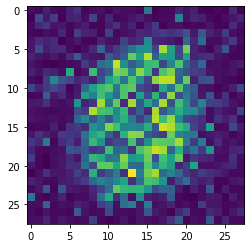

tensor(8, device='cuda:0')


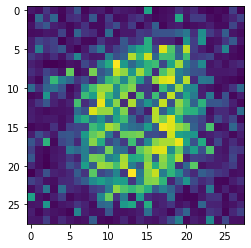

tensor(1, device='cuda:0')


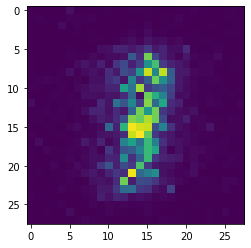

epoch: 0 generator_loss: 22.505558076830706 discriminator_loss: 2.8107492825122065
epoch: 1 generator_loss: 26.22494329602321 discriminator_loss: 3.1665580944390483
epoch: 2 generator_loss: 29.882723313748837 discriminator_loss: 3.55738857728356
epoch: 3 generator_loss: 33.05981438360612 discriminator_loss: 4.030155955915787
epoch: 4 generator_loss: 35.752931612432 discriminator_loss: 4.603019955052076
epoch: 5 generator_loss: 38.105337291944025 discriminator_loss: 5.259684397948919
epoch: 6 generator_loss: 40.395493317512674 discriminator_loss: 5.912806522334753
epoch: 7 generator_loss: 42.53184816198746 discriminator_loss: 6.624255474262574
epoch: 8 generator_loss: 44.54877630253235 discriminator_loss: 7.372432729559281
epoch: 9 generator_loss: 46.33242226909399 discriminator_loss: 8.212126724701264
torch.Size([10, 28, 28])
(10, 28, 28)
epoch: 10
tensor(7, device='cuda:0')


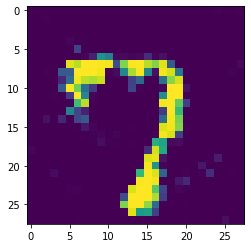

tensor(5, device='cuda:0')


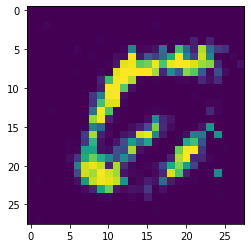

tensor(4, device='cuda:0')


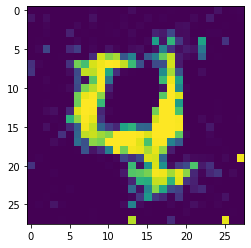

tensor(3, device='cuda:0')


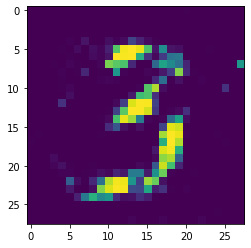

tensor(8, device='cuda:0')


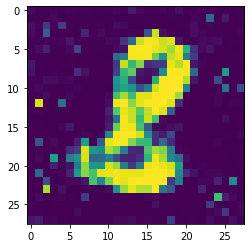

tensor(1, device='cuda:0')


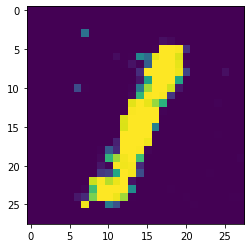

tensor(1, device='cuda:0')


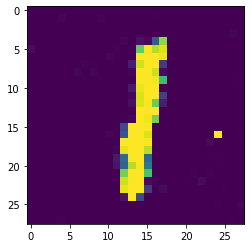

tensor(1, device='cuda:0')


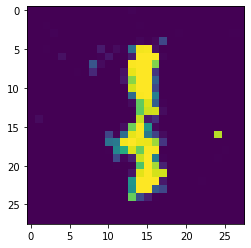

tensor(4, device='cuda:0')


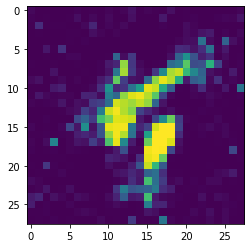

tensor(9, device='cuda:0')


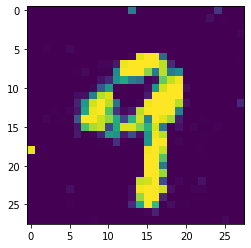

epoch: 10 generator_loss: 47.99830751562516 discriminator_loss: 9.101222918030757
epoch: 11 generator_loss: 49.54477321796815 discriminator_loss: 10.036929720939337
epoch: 12 generator_loss: 51.06796310186783 discriminator_loss: 10.992447706505795
epoch: 13 generator_loss: 52.505496232227486 discriminator_loss: 11.97952366018011
epoch: 14 generator_loss: 53.851520478125416 discriminator_loss: 13.011182827342688
epoch: 15 generator_loss: 55.16782857234081 discriminator_loss: 14.052240449362138
epoch: 16 generator_loss: 56.40941566168865 discriminator_loss: 15.131421296784419
epoch: 17 generator_loss: 57.59304727036556 discriminator_loss: 16.24351969817195
epoch: 18 generator_loss: 58.76855206896862 discriminator_loss: 17.357489891748767
epoch: 19 generator_loss: 59.90676038535833 discriminator_loss: 18.491295769625047


In [130]:
num_epochs = 20
batch_size=32

generator_loss = []
discriminator_loss = []
for epoch in range(0,num_epochs+1):
    g_loss_1 = 0
    d_loss_1 = 0
    for i, batch in enumerate(train_dataloader):
        images,labels = batch
        labels = labels
        real_images = images
        step = epoch * len(train_dataloader) + i + 1
        real_images = images.cuda()
        labels = labels.cuda()
        generator_model.train()
        
        d_loss = discriminator_train_step(len(real_images), discriminator_model,
                                          generator_model, d_optimizer, criterion,
                                          real_images, labels)


        g_loss = generator_train_step(batch_size, discriminator_model, generator_model, g_optimizer, criterion)
        
        g_loss_1 = g_loss_1 + g_loss
        d_loss_1 = d_loss_1+d_loss
        
    if epoch ==0 or epoch == 10 or epoch== 20:
        generator_model.eval()
        z = Variable(torch.randn(10, 100)).cuda()
        labels = Variable(torch.LongTensor(np.random.randint(1,10,10))).cuda()
        sample_images = generator_model(z, labels)
        samples1 = sample_images.detach().cpu().numpy()
        print(samples1.shape)
        print("epoch:",epoch)
        for i in range(10):
          img = samples1[i]
          img = img.reshape(28,28)
          print(labels[i])
          plt.imshow(img)
          plt.show()


    generator_loss.append(g_loss_1/len(train_dataloader))
    discriminator_loss.append(d_loss_1/len(train_dataloader))
    print("epoch:",epoch,"generator_loss:",g_loss_1/len(train_dataloader),"discriminator_loss:",d_loss_1/len(train_dataloader)) 


 


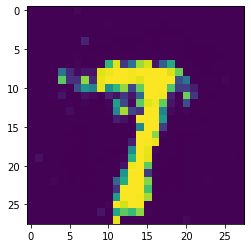

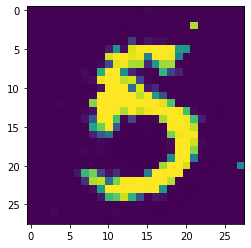

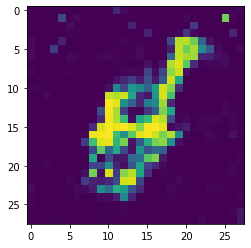

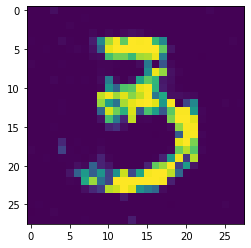

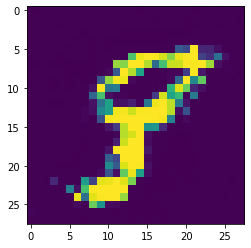

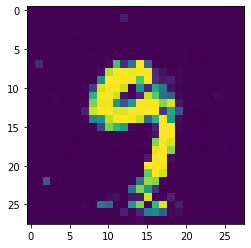

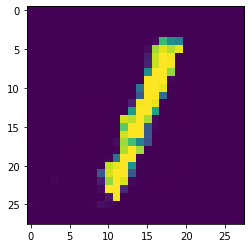

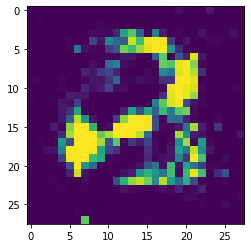

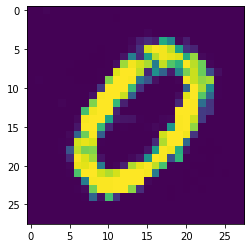

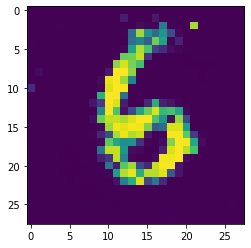

In [141]:
def generate_digit(generator_model, digit):
    z = Variable(torch.randn(1, 100)).cuda()
    label = torch.LongTensor([digit]).cuda()
    img = generator_model(z, label).data.cpu()
    return T.ToPILImage()(img)

out = generate_digit(generator_model, 7)
plt.imshow(out)
plt.show()


out = generate_digit(generator_model, 5)
plt.imshow(out)
plt.show()


out = generate_digit(generator_model, 4)
plt.imshow(out)
plt.show()

out = generate_digit(generator_model, 3)
plt.imshow(out)
plt.show()

out = generate_digit(generator_model, 8)
plt.imshow(out)
plt.show()

out = generate_digit(generator_model, 9)
plt.imshow(out)
plt.show()


out = generate_digit(generator_model, 1)
plt.imshow(out)
plt.show()


out = generate_digit(generator_model, 2)
plt.imshow(out)
plt.show()

out = generate_digit(generator_model, 0)
plt.imshow(out)
plt.show()

out = generate_digit(generator_model, 6)
plt.imshow(out)
plt.show()
